- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
- [image source](https://xiaohongliu.ca/post/gan/)

## Library

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
torch.__version__    

'1.13.1+cu117'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.manual_seed(2023)

## Hyperparameters

In [6]:
"""
학습에 사용될 hyperparameter 값들을 넣을 class를 정의합니다.
"""
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [7]:
"""
GAN model 학습에 사용되는 결과 이미지 저장 경로, 에포크 수, 모델 입력 이미지 크기 등을 정의합니다.
"""
config = AttrDict()
config.data_path = 'data/resource_2/' 
config.save_path = 'save/DCGAN_64_______a/'
#config.dataset = 'CIFAR10' #CIFAR10 어떠한 데이터셋을 사용하는지
config.dataset = 'emoji'

config.n_epoch = 200
config.log_interval = 150 # loss 출력
config.save_interval = 5  # 이미지 출력
config.batch_size = 200

config.nz = 100
config.ngf = 128 # generator oonv filter
config.ndf = 128 # discriminator oonv fillter

config.learning_rate = 0.00001
config.b1 = 0.5
config.b2 = 0.999
config.img_shape = (3, 64, 64) # c, w, h
config.latent_size = 100 # random noise size
"""
모델 입력 이미지에 수행할 normalization과 모델 생성 결과 이미지에 수행할 denormalization을 정의합니다.
"""
config.mu = torch.ones((3),device='cuda', dtype=torch.float32)
config.sigma = torch.ones((3),device='cuda', dtype=torch.float32)


config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])), #resize
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) #normalization
                      ])
config.denormalize = lambda x: x*0.5+0.5 #denormalization 위의 단계 reverse , 원래의 이미지를 보기 위해 수행함

config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cuda에 올리기

In [8]:
a = torch.tensor([1,0,0])
b = torch.ones((2))
a, b

(tensor([1, 0, 0]), tensor([1., 1.]))

In [9]:
#지정된 경로의 데이터셋 가져오기 및 저장
if not os.path.isdir(config.data_path):
    os.makedirs(config.data_path)
if not os.path.isdir(os.path.join(config.save_path, config.dataset)):
    os.makedirs(os.path.join(config.save_path, config.dataset))

In [10]:
config.device

device(type='cuda')

## Data load

In [11]:
"""
MNIST와 CIFAR-10은 torchvision 라이브러리에서 제공하여 아래와 같이 사용할 수 있습니다.
"""
                                 
if config.dataset == 'CIFAR10': 
    train_dataset = datasets.CIFAR10(config.data_path,
                                       train=True,
                                       download=True,
                                       transform=config.augmentation
                                     )
elif config.dataset == 'emoji': 
    train_dataset = datasets.ImageFolder(config.data_path,
                                         transform=config.augmentation
                                     )

print(config.dataset)
    
"""
training set을 Dataloader에 넣습니다. 
"""
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers = 2)
print(train_dataset)

emoji
Dataset ImageFolder
    Number of datapoints: 6000
    Root location: data/resource_2/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [12]:
len(train_dataset)

6000

In [13]:
img, label = train_dataset[0]

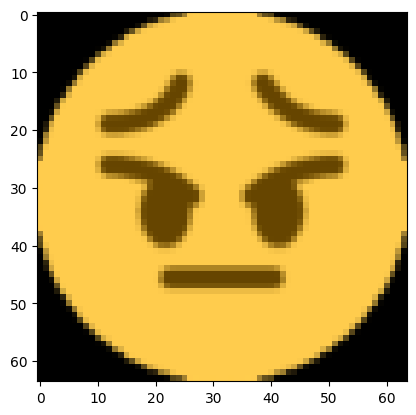

In [14]:
plt.imshow(to_pil_image(0.5*img+0.5))

## custom data

로컬 디렉토리 image 가져오기

In [15]:
import urllib.request
import zipfile
import glob

In [16]:
data_path = ''
glob.glob('data/resource/emoji/*')[:20]

[]

In [17]:
train_loader

## GAN model

In [18]:
config.img_shape

(3, 64, 64)

In [19]:
"""
 일반적으로, GAN에서는 loss가 Discriminator에서부터 Generator로 흐를 때 생길 수 있는 
 vanishing gradient 현상을 완화하기 위해 Leaky ReLU를 많이 사용합니다. 
"""
class Generator(nn.Module): # 입력으로 noise를 받음
    def __init__(self, config):
        super().__init__()
        config.mu.requires_grad = True
        config.sigma.requires_grad = True
        
        self.mu = nn.Parameter(config.mu)
        self.sigma = nn.Parameter(config.sigma)
        
        self.dconv1 = nn.ConvTranspose2d(config.latent_size, config.ngf*8, 4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(config.ngf*8)
        #62
            
        self.dconv2 = nn.ConvTranspose2d(config.ngf*8, config.ngf*4, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(config.ngf*4)
        #15   
            
        self.dconv3 = nn.ConvTranspose2d(config.ngf*4, config.ngf*2, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(config.ngf*2)
            
        self.dconv4 = nn.ConvTranspose2d(config.ngf*2, config.ngf,4,stride=2,padding=1)
        self.bn4 = nn.BatchNorm2d(config.ngf)
            
        self.dconv5 = nn.ConvTranspose2d(config.ngf, config.img_shape[0], 4,stride=2, padding=1)
        
    def forward(self, z, z_label):
        z = z*self.sigma[z_label.long()]+self.mu[z_label.long()]
        print(z)
        
        x = z.reshape(real_img.shape[0], config.latent_size,1,1)
        x = F.leaky_relu(self.bn1(self.dconv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.dconv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.dconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.dconv4(x)), 0.2)
        x = torch.tanh(self.dconv5(x))
        #img = img.reshape(img.shape[0], *config.img_shape)
        return x

In [20]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv2d(config.img_shape[0],config.ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(config.ndf,config.ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(config.ndf*2)
        
        self.conv3 = nn.Conv2d(config.ndf*2, config.ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(config.ndf*4)
        
        self.conv4 = nn.Conv2d(config.ndf*4,config.ndf*6,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(config.ndf*6)
        
        self.conv5 = nn.Conv2d(config.ndf*6,config.ndf*8,4,stride=1,padding=0,bias=False)
        self.bn5 = nn.BatchNorm2d(config.ndf*8)
        
        self.lin1 = nn.Linear(1024, 300)
        self.bn6 = nn.BatchNorm1d(300)
        
        self.lin2 = nn.Linear(300, 4)

    def forward(self,x):
        print(x.shape)
        x = F.leaky_relu(self.conv1(x),0.2)
        print(x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        print(x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        print(x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        print(x.shape)
        x = F.leaky_relu(self.bn5(self.conv5(x)),0.2)
        print(x.shape)
        
        #-------------------------------------------------------------
        x = x.view(x.size(0),-1)
        print(x.shape)
        #x = F.leaky_relu(self.lin1(x),0.2)
        
        x = F.leaky_relu(self.bn6(self.lin1(x)),0.2)
        print(x.shape)
        x = F.leaky_relu(self.lin2(x),0.2)
        print(x.shape)
        x = torch.softmax(x, dim=1)
        
        print(x.shape)
        print(x.argmax())
        print('--------------------------------------------------')
        return x

#### Binary Cross Entropy loss between the target and the input probabilities

- [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [21]:
"""
binary cross entropy loss를 사용하여 adversarial loss를 구현합니다.
"""
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss().to(config.device)
"""
Generator와 Discriminator를 각각 정의하고, 상응하는 optimizer도 함께 정의합니다.
"""
generator = Generator(config).to(config.device)
discriminator = Discriminator(config).to(config.device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))

In [22]:
import random
import numpy as np
def generate_random_one_hot(size):
    for _ in range(200):
        label_vector = [0 for _ in range(4)]
        random_idx = random.randint(0,size-1)
        label_vector[random_idx] = 1.0
        #label_tensor.append(label)
    return label_vector, random_idx


In [23]:
generate_random_one_hot(3)

([0, 0, 1.0, 0], 2)

In [24]:
# z = torch.randn((real_img.shape[0], 97), device=config.device, dtype=torch.float32)
# label = generate_random_one_hot(3).to(config.device)
# print(z+label)


def one_hot(label):
    label_list = list()
    for i in label:
        label_vector = [0 for _ in range(4)]
        random_idx = i
        label_vector[random_idx] = 1.0
        label_list.append(label_vector)
    return np.array(label_list)

                                  
    

In [25]:
one_hot([1,3,0])

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [26]:
def generate_random_latent(size):
    z = list()
    z_on = list()
    z_la = list()
    for _ in range(size):
        z_random = np.random.randn(96)
        z_label_vector,la = generate_random_one_hot(3)
        z_random =np.concatenate((z_random,z_label_vector),axis=0)
        z.append(z_random)
        z_on.append(z_label_vector)
        z_la.append(la)
        
    return np.array(z), np.array(z_on), np.array(z_la)

In [27]:
a, b, c=generate_random_latent(200)
a, b, c

(array([[ 0.87178152, -0.09288492,  0.55941801, ...,  1.        ,
          0.        ,  0.        ],
        [-0.02098843, -0.40798985,  0.50519442, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.3541047 ,  0.18273471,  0.06328464, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [-0.91071714,  0.35515731, -0.52363823, ...,  1.        ,
          0.        ,  0.        ],
        [-0.2323609 ,  0.47911707, -0.00923808, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.00878375,  0.34684822, -0.89321701, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [

## Training

In [ ]:
"""
Generator와 Discriminator를 번갈아 학습합니다.
"""
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, real_label) in enumerate(train_loader):
        # 실제 이미지
        real_img, real_label = real_img.to(config.device), real_label.to(config.device)
        real_label = one_hot(real_label)
        #print(real_label)
        #print(real_label.shape)
        real_label =torch.tensor(real_label).to(config.device)
        real_label = real_label.type(torch.float32)
        
        #real_label=real_label.reshape(200,1)
        optimizer_d.zero_grad()
        
        #label
        #valid_label = torch.ones((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        #fake_label = torch.tensor((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        fake_label = torch.tensor([0,0,0,1]*200, device=config.device, dtype=torch.float32)
        fake_label= fake_label.reshape(200,4)
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#

        
        #latent 생성
        #z = torch.randn((real_img.shape[0], 97,1,1), device=config.device, dtype=torch.float32)
        #z = generate_random_latent(200).to(config.device)
        #z = torch.randn((real_img.shape[0], 97), device=config.device, dtype=torch.float32)
        #label = generate_random_one_hot(3).to(config.device)
        
        z, z_on, z_label = generate_random_latent(200)
        #print(z_label)
        z_label = z_label.reshape(200,1)
        z,z_on ,z_label = (torch.tensor(z,dtype=torch.float32).to(config.device),
                            torch.tensor(z_on,dtype=torch.float32).to(config.device),
                            torch.tensor(z_label,dtype=torch.float32).to(config.device))
    
        
        gen_img = generator(z, z_label)
        

        ## D loss
        r = discriminator(real_img)
        #print('r',r)
        #print('r.shape',r.shape)
              
        real_loss = criterion(r, real_label)
        #print('real',real_loss.item())
        # G_loss
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label) # detach generator는 가중치 업데이트 안함
        #print('fake',fake_loss.item())

        d_loss = (real_loss + fake_loss) * 0.5
        #print('d',d_loss.item())

        
        d_loss.backward() # 여기서 grediant가 업데이트 안됨
        optimizer_d.step()
   
            

        
        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#

        """
        Generator가 Discriminator를 속일 수 있는지 loss를 계산합니다.
        """

        g_loss = criterion(discriminator(gen_img), z_on) #valid_label로 하여 generator를 학습하게 함
        #print('g',g_loss.item())
   
        
        """
        Generator를 업데이트합니다.
        """
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
    
  
        if (i+1) % len(train_loader) == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator_1 loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1,
                config.n_epoch,
                i+1,
                len(train_loader),
                g_loss.item(),
                d_loss.item()
            ))
                
            
    if (epoch+1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, config.dataset, 'epoch_[{0:-03d}]_.png'.format(
            epoch+1
        ))
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:16], save_path, nrow=4, normalize=True)

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([[ 2.4479,  2.9822,  2.2658,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.9454,  0.7420,  0.6650,  ...,  1.0000,  2.0000,  1.0000],
        [ 1.4390, -0.6642, -0.0720,  ...,  2.0000,  1.0000,  1.0000],
        ...,
        [ 1.3797,  0.7632,  0.6133,  ...,  1.0000,  2.0000,  1.0000],
        [ 1.6271,  1.1690,  1.7394,  ...,  2.0000,  1.0000,  1.0000],
        [ 1.2356,  1.2448,  0.2470,  ...,  1.0000,  1.0000,  1.0000]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(347, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor(755, device='cuda:0')
--------------------------------------------------
tensor([[ 2.0320,  0.3769,  1.0845,  ...,  2.0000,  1.0001,  1.0001],
        [-0.3878,  0.2069,  3.2212,  ...,  2.0000,  1.0001,  1.0001],
        [ 1.4923,  1.9773, -0.2368,  ...,  2.0000,  1.0001,  1.0001],
        ...,
        [ 2.2234,  0.5983,  0.3301,  ...,  1.0001,  1.0001,  1.0001],
        [ 0.4116,  0.1868,  2.3531,  ...,  1.0001,  1.0001,  1.0001],
        [ 1.7039,  2.0235,  1.9837,  ...,  1.0001,  1.0001,  1.0001]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(206, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(375, device='cuda:0')
--------------------------------------------------
tensor([[ 0.2031,  2.8749,  0.9166,  ...,  1.0001,  1.0001,  1.0001],
        [ 1.0838,  1.5390,  2.0130,  ...,  2.0000,  1.0001,  1.0001],
        [ 1.2462,  0.0080,  1.1561,  ...,  2.0000,  1.0001,  1.0001],
        ...,
        [-0.3716,  1.8994,  1.2944,  ...,  2.0000,  1.0001,  1.0001],
        [ 0.2361,  1.5265,  3.2424,  ...,  2.0000,  1.0001,  1.0001],
        [ 1.9452, -0.5879,  3.0397,  ...,  1.0001,  1.0001,  1.0001]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(240, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(451, device='cuda:0')
--------------------------------------------------
tensor([[-0.4682, -0.7886,  0.5766,  ...,  1.0002,  1.0002,  1.0002],
        [ 2.2906,  1.0533,  1.0723,  ...,  1.0000,  2.0000,  1.0000],
        [ 0.3411,  3.7972,  1.5691,  ...,  1.0000,  2.0000,  1.0000],
        ...,
        [ 1.3709,  0.8711,  0.7157,  ...,  1.9999,  1.0001,  1.0001],
        [ 0.0490, -0.0969,  1.9459,  ...,  1.9999,  1.0001,  1.0001],
        [ 1.2524,  2.6772,  1.2173,  ...,  1.9999,  1.0001,  1.0001]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(474, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(503, device='cuda:0')
--------------------------------------------------
tensor([[ 0.8023,  2.5766,  0.7096,  ...,  1.0002,  1.0002,  1.0002],
        [ 1.4088,  0.3255, -0.1264,  ...,  1.0000,  2.0000,  1.0000],
        [ 1.8447,  0.7705,  1.3112,  ...,  1.0002,  1.0002,  1.0002],
        ...,
        [ 2.0108,  2.0877,  0.9686,  ...,  1.9999,  1.0002,  1.0002],
        [ 1.7206,  0.5772,  1.5698,  ...,  1.9999,  1.0002,  1.0002],
        [ 0.3496,  0.5171,  2.2539,  ...,  1.0000,  2.0000,  1.0000]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(662, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(711, device='cuda:0')
--------------------------------------------------
Epoch [1/200] Batch [30/30] Discriminator_1 loss: 0.5226 Generator loss: 0.2995
tensor([[0.5874, 0.8742, 1.7015,  ..., 1.0001, 2.0001, 1.0001],
        [0.0618, 0.1426, 1.4788,  ..., 1.9999, 1.0003, 1.0003],
        [0.3414, 2.1587, 2.3568,  ..., 1.9999, 1.0003, 1.0003],
        ...,
        [1.6329, 0.0210, 1.2334,  ..., 1.0001, 2.0001, 1.0001],
        [0.9833, 1.5659, 1.5525,  ..., 1.0001, 2.0001, 1.0001],
        [0.8294, 1.0936, 1.8741,  ..., 1.9999, 1.0003, 1.0003]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(370, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 

tensor([[ 2.6691,  2.1617,  0.6193,  ...,  1.0004,  1.0004,  1.0004],
        [ 0.8694,  2.1126,  0.2628,  ...,  1.0002,  2.0001,  1.0002],
        [-0.0560,  0.2551,  1.1756,  ...,  1.0002,  2.0001,  1.0002],
        ...,
        [ 1.0507,  1.4948,  0.8170,  ...,  1.0002,  2.0001,  1.0002],
        [ 0.1798,  1.6553,  2.8181,  ...,  1.0002,  2.0001,  1.0002],
        [-0.2725,  0.1133,  1.2293,  ...,  1.0002,  2.0001,  1.0002]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(208, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 2.4962,  0.6995,  2.0459,  ...,  1.9999,  1.0004,  1.0004],
        [ 2.5460,  1.4589,  0.3990,  ...,  1.9999,  1.0004,  1.0004],
        [ 0.3713,  0.3076,  0.2335,  ...,  1.0004,  1.0004,  1.0004],
        ...,
        [ 1.1751,  0.1124,  1.3110,  ...,  1.0004,  1.0004,  1.0004],
        [ 0.6870,  2.1782,  1.1687,  ...,  1.0003,  2.0001,  1.0003],
        [ 0.4660, -0.2422, -0.1127,  ...,  1.0003,  2.0001,  1.0003]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(432, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 2.0734,  2.7701, -0.1399,  ...,  1.0005,  1.0005,  1.0005],
        [-0.0330,  0.1255, -0.8867,  ...,  1.0004,  2.0001,  1.0004],
        [ 1.6559,  0.7677,  0.2118,  ...,  1.0004,  2.0001,  1.0004],
        ...,
        [ 1.8395,  2.3091,  0.6393,  ...,  1.9999,  1.0005,  1.0005],
        [ 1.8195,  1.9584,  2.5042,  ...,  1.0004,  2.0001,  1.0004],
        [ 1.3631, -0.4561,  0.3894,  ...,  1.0005,  1.0005,  1.0005]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(573, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 0.1034,  0.8731,  1.1399,  ...,  1.9999,  1.0006,  1.0006],
        [ 2.2442,  1.5751,  1.9625,  ...,  1.0006,  1.0006,  1.0006],
        [ 2.4619, -0.4829,  0.3792,  ...,  1.9999,  1.0006,  1.0006],
        ...,
        [ 1.9500,  0.5791,  0.8361,  ...,  1.0006,  1.0006,  1.0006],
        [ 2.0649,  1.2506,  0.8254,  ...,  1.0004,  2.0001,  1.0004],
        [ 3.4147,  1.8612,  1.2903,  ...,  1.0006,  1.0006,  1.0006]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(14, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024,

Epoch [2/200] Batch [30/30] Discriminator_1 loss: 0.5659 Generator loss: 0.2798
tensor([[ 1.2321,  1.9654,  0.0482,  ...,  1.0006,  1.0006,  1.0006],
        [-0.1397,  0.1581,  1.4371,  ...,  1.0005,  2.0001,  1.0005],
        [ 1.7190,  1.9617,  0.3781,  ...,  2.0000,  1.0007,  1.0007],
        ...,
        [ 1.2816,  0.4608,  0.1219,  ...,  2.0000,  1.0007,  1.0007],
        [ 1.0119, -0.2855,  1.1767,  ...,  1.0006,  1.0006,  1.0006],
        [ 1.4025,  2.0818,  1.3522,  ...,  1.0006,  1.0006,  1.0006]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(264, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(463, device='cuda:0')
--------------------------------------------------
tensor([[ 0.2386,  0.9405, -0.6094,  ...,  2.0000,  1.0008,  1.0008],
        [-0.1778,  1.7117, -0.5180,  ...,  1.0006,  2.0001,  1.0006],
        [-1.0536,  0.6968,  0.8328,  ...,  2.0000,  1.0008,  1.0008],
        ...,
        [ 0.2209,  0.8947,  0.4460,  ...,  1.0006,  2.0001,  1.0006],
        [ 2.0022,  2.0321,  0.0304,  ...,  2.0000,  1.0008,  1.0008],
        [ 2.5796,  1.4908,  0.3674,  ...,  1.0006,  2.0001,  1.0006]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(440, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(367, device='cuda:0')
--------------------------------------------------
tensor([[ 0.7774,  1.9350,  1.4628,  ...,  1.0006,  2.0001,  1.0006],
        [ 2.3075,  1.8439,  1.9445,  ...,  1.0008,  1.0008,  1.0008],
        [ 2.4751,  2.8154,  3.9148,  ...,  1.0008,  1.0008,  1.0008],
        ...,
        [ 1.7212,  1.4405, -0.2860,  ...,  1.0008,  1.0008,  1.0008],
        [ 2.7138,  2.7241,  0.4302,  ...,  1.0008,  1.0008,  1.0008],
        [-0.2846,  0.9847, -0.4070,  ...,  2.0000,  1.0009,  1.0009]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(304, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(127, device='cuda:0')
--------------------------------------------------
tensor([[ 0.6437,  2.6836,  1.1674,  ...,  1.0008,  1.0008,  1.0008],
        [ 1.4171,  0.1500,  0.7049,  ...,  1.0008,  1.0008,  1.0008],
        [-0.6883,  0.6957,  0.9865,  ...,  1.0007,  2.0001,  1.0007],
        ...,
        [ 0.2616, -0.3354,  0.2929,  ...,  2.0000,  1.0010,  1.0010],
        [ 2.5265,  0.3843,  2.6629,  ...,  2.0000,  1.0010,  1.0010],
        [ 2.2422,  1.7604,  2.4404,  ...,  1.0008,  1.0008,  1.0008]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(374, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(447, device='cuda:0')
--------------------------------------------------
tensor([[ 1.0396,  0.7905,  1.0869,  ...,  2.0000,  1.0011,  1.0011],
        [ 0.8531,  2.0360,  1.1307,  ...,  1.0008,  2.0000,  1.0008],
        [ 1.9017,  0.8646, -0.7594,  ...,  2.0000,  1.0011,  1.0011],
        ...,
        [ 1.3269,  1.0477,  1.2496,  ...,  1.0008,  2.0000,  1.0008],
        [ 1.8126,  1.0453,  1.7680,  ...,  1.0009,  1.0009,  1.0009],
        [ 1.8302, -0.5058,  1.6106,  ...,  1.0009,  1.0009,  1.0009]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(566, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(419, device='cuda:0')
--------------------------------------------------
Epoch [3/200] Batch [30/30] Discriminator_1 loss: 0.5938 Generator loss: 0.2637
tensor([[ 1.0399,  1.2963,  2.0302,  ...,  1.0008,  2.0000,  1.0008],
        [ 1.5918,  0.0817,  1.0873,  ...,  2.0001,  1.0012,  1.0012],
        [ 0.9165,  2.0391,  2.0528,  ...,  2.0001,  1.0012,  1.0012],
        ...,
        [ 0.1475,  1.1958,  2.5275,  ...,  2.0001,  1.0012,  1.0012],
        [ 2.3594,  0.9367, -1.8530,  ...,  1.0008,  2.0000,  1.0008],
        [ 0.9158, -1.5773,  1.6696,  ...,  1.0008,  2.0000,  1.0008]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(226, device='cuda:0')
--------------------------------------------------
torch.Size

tensor(323, device='cuda:0')
--------------------------------------------------
tensor([[ 0.5892,  1.8442,  0.9501,  ...,  2.0001,  1.0013,  1.0013],
        [ 1.4690,  3.2122,  0.8125,  ...,  1.0008,  1.9999,  1.0008],
        [ 0.1453, -0.9502,  0.2062,  ...,  2.0001,  1.0013,  1.0013],
        ...,
        [ 1.8235,  0.2721,  1.1722,  ...,  1.0008,  1.9999,  1.0008],
        [ 1.3485,  1.5318,  2.1159,  ...,  2.0001,  1.0013,  1.0013],
        [ 1.1570,  0.7287,  1.4017,  ...,  2.0001,  1.0013,  1.0013]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(784, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(695, device='cuda:0')
--------------------------------------------------
tensor([[0.9019, 1.2374, 0.5073,  ..., 2.0001, 1.0014, 1.0014],
        [1.6276, 1.6935, 0.7549,  ..., 2.0001, 1.0014, 1.0014],
        [0.4148, 0.9274, 2.1325,  ..., 1.0009, 1.9998, 1.0009],
        ...,
        [1.4471, 0.5913, 1.3109,  ..., 1.0011, 1.0011, 1.0011],
        [0.3109, 1.9052, 2.7179,  ..., 1.0009, 1.9998, 1.0009],
        [2.3409, 3.1452, 2.1629,  ..., 1.0011, 1.0011, 1.0011]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(566, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.

tensor(291, device='cuda:0')
--------------------------------------------------
tensor([[ 0.1581, -0.1934, -1.1423,  ...,  1.0011,  1.0011,  1.0011],
        [ 2.7865,  0.3937,  0.9463,  ...,  1.0009,  1.9997,  1.0009],
        [ 3.0625,  1.5801,  0.6977,  ...,  1.0011,  1.0011,  1.0011],
        ...,
        [ 1.2539,  0.7064,  0.9342,  ...,  2.0002,  1.0016,  1.0016],
        [ 2.5540,  0.2876,  0.0575,  ...,  1.0011,  1.0011,  1.0011],
        [ 0.5222, -0.0251, -0.1713,  ...,  2.0002,  1.0016,  1.0016]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(790, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(751, device='cuda:0')
--------------------------------------------------
tensor([[ 1.2879,  2.7526,  0.8696,  ...,  2.0003,  1.0017,  1.0017],
        [ 0.4961,  0.2926, -1.7739,  ...,  1.0012,  1.0012,  1.0012],
        [ 0.8917,  0.7677,  1.3700,  ...,  1.0012,  1.0012,  1.0012],
        ...,
        [ 0.5446,  1.8804, -1.1228,  ...,  1.0009,  1.9996,  1.0009],
        [ 0.5171,  0.1189,  2.2147,  ...,  1.0009,  1.9996,  1.0009],
        [-1.6042,  0.3970,  1.7077,  ...,  1.0012,  1.0012,  1.0012]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(764, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor(751, device='cuda:0')
--------------------------------------------------
Epoch [4/200] Batch [30/30] Discriminator_1 loss: 0.6123 Generator loss: 0.2597
tensor([[ 0.8211,  2.5476, -0.0613,  ...,  1.0009,  1.9995,  1.0009],
        [ 1.0054,  0.6239,  1.7955,  ...,  2.0003,  1.0018,  1.0018],
        [ 0.9414,  1.0510,  0.6826,  ...,  2.0003,  1.0018,  1.0018],
        ...,
        [ 1.0328,  1.4013,  2.3541,  ...,  1.0009,  1.9995,  1.0009],
        [ 0.0655,  2.9206,  2.4386,  ...,  2.0003,  1.0018,  1.0018],
        [ 2.3140,  2.3407,  0.2181,  ...,  2.0003,  1.0018,  1.0018]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(224, device='cuda:0')
--------------------------------------------------
torch.Size

tensor([[ 1.0109,  0.2454,  1.6294,  ...,  1.0013,  1.0013,  1.0013],
        [ 0.3385,  1.2052,  0.2983,  ...,  1.0009,  1.9995,  1.0009],
        [ 0.7282,  0.6020,  0.5085,  ...,  1.0013,  1.0013,  1.0013],
        ...,
        [ 2.2853, -0.0663, -0.3312,  ...,  1.0013,  1.0013,  1.0013],
        [ 2.9554,  0.5017,  1.1858,  ...,  1.0009,  1.9995,  1.0009],
        [-0.5128,  0.7959,  1.8481,  ...,  1.0013,  1.0013,  1.0013]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(298, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[-1.1681, -0.9451,  0.0727,  ...,  1.0013,  1.0013,  1.0013],
        [ 1.0981,  0.8141,  3.1484,  ...,  2.0004,  1.0020,  1.0020],
        [-0.9283,  1.4898,  1.0537,  ...,  2.0004,  1.0020,  1.0020],
        ...,
        [ 1.3843,  2.0956, -0.6119,  ...,  2.0004,  1.0020,  1.0020],
        [ 0.5881,  1.9878,  1.8229,  ...,  1.0010,  1.9994,  1.0010],
        [ 0.9733,  0.1705, -0.5267,  ...,  2.0004,  1.0020,  1.0020]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(81, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024,

tensor([[-0.4140,  1.3473,  0.7543,  ...,  1.0014,  1.0014,  1.0014],
        [ 0.7822,  0.8293, -0.7762,  ...,  1.0014,  1.0014,  1.0014],
        [-0.3770,  2.3144,  0.2479,  ...,  1.0014,  1.0014,  1.0014],
        ...,
        [ 2.4385,  2.6258,  0.1985,  ...,  1.0010,  1.9994,  1.0010],
        [ 1.4469,  1.3768,  1.5540,  ...,  1.0010,  1.9994,  1.0010],
        [ 1.5772,  0.1910, -1.1207,  ...,  2.0004,  1.0021,  1.0021]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(626, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 2.0745,  2.6520,  0.0659,  ...,  2.0004,  1.0021,  1.0021],
        [ 2.3252,  2.9290,  1.5550,  ...,  2.0004,  1.0021,  1.0021],
        [ 3.0271,  0.4175, -0.0597,  ...,  1.0011,  1.9994,  1.0011],
        ...,
        [-0.0940,  0.0565,  2.2221,  ...,  1.0011,  1.9994,  1.0011],
        [-0.2977,  0.5527,  1.8075,  ...,  1.0015,  1.0015,  1.0015],
        [ 0.9520,  1.1634,  1.2348,  ...,  1.0011,  1.9994,  1.0011]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(348, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

Epoch [5/200] Batch [30/30] Discriminator_1 loss: 0.6364 Generator loss: 0.2488
tensor([[-0.5168,  1.9746,  2.9675,  ...,  1.0016,  1.0016,  1.0016],
        [-0.0338,  1.2367,  0.9640,  ...,  2.0004,  1.0022,  1.0022],
        [ 2.2651,  1.3000,  0.3422,  ...,  2.0004,  1.0022,  1.0022],
        ...,
        [ 0.2156,  1.7445,  1.6743,  ...,  1.0016,  1.0016,  1.0016],
        [ 1.1536,  1.0012,  0.6733,  ...,  1.0011,  1.9993,  1.0011],
        [ 1.6496, -0.2090,  2.1536,  ...,  1.0011,  1.9993,  1.0011]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(98, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])


tensor([[ 0.7260,  1.9807, -0.1670,  ...,  1.0012,  1.9993,  1.0012],
        [ 1.8881,  0.2201,  1.3932,  ...,  2.0004,  1.0023,  1.0023],
        [ 0.2819,  1.6139,  0.7304,  ...,  1.0017,  1.0017,  1.0017],
        ...,
        [ 2.8434, -1.2711,  0.9315,  ...,  1.0012,  1.9993,  1.0012],
        [ 1.4991,  1.5615,  1.0944,  ...,  2.0004,  1.0023,  1.0023],
        [ 1.3565,  0.0402,  0.8625,  ...,  2.0004,  1.0023,  1.0023]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(728, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 1.9822,  0.9213,  2.2760,  ...,  2.0004,  1.0024,  1.0024],
        [-0.3387,  0.0730,  1.6554,  ...,  1.0017,  1.0017,  1.0017],
        [ 0.1131,  0.5797,  0.5054,  ...,  1.0013,  1.9993,  1.0013],
        ...,
        [ 0.3408,  0.2329,  1.3331,  ...,  2.0004,  1.0024,  1.0024],
        [-0.6237,  0.5985,  0.0602,  ...,  2.0004,  1.0024,  1.0024],
        [ 1.9929,  1.6004,  0.4352,  ...,  1.0013,  1.9993,  1.0013]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(430, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 0.8077,  2.0012,  1.3229,  ...,  1.0018,  1.0018,  1.0018],
        [ 0.9666,  0.7048, -0.1326,  ...,  1.0013,  1.9992,  1.0013],
        [ 2.1202,  1.2582,  1.2130,  ...,  1.0018,  1.0018,  1.0018],
        ...,
        [ 1.1967,  0.8937,  2.2585,  ...,  1.0018,  1.0018,  1.0018],
        [ 1.8845,  2.7652,  0.4121,  ...,  1.0018,  1.0018,  1.0018],
        [ 0.4492,  2.6216, -0.0519,  ...,  1.0013,  1.9992,  1.0013]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(49, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024,

tensor([[ 1.7007,  0.6237, -1.7492,  ...,  1.0019,  1.0019,  1.0019],
        [-0.0878,  2.3795, -0.3478,  ...,  1.0019,  1.0019,  1.0019],
        [ 1.6918,  0.7375,  1.6092,  ...,  1.0014,  1.9992,  1.0014],
        ...,
        [-0.1787,  1.1323,  1.1076,  ...,  2.0005,  1.0025,  1.0025],
        [ 0.2052, -0.4817,  1.5463,  ...,  1.0014,  1.9992,  1.0014],
        [-0.0327, -1.7587,  0.3112,  ...,  1.0019,  1.0019,  1.0019]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(598, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

Epoch [6/200] Batch [30/30] Discriminator_1 loss: 0.6847 Generator loss: 0.2332
tensor([[ 0.3065,  0.7816,  0.7668,  ...,  1.0021,  1.0021,  1.0021],
        [ 2.2328,  1.2795, -0.0215,  ...,  2.0004,  1.0025,  1.0025],
        [-0.2427,  0.6323,  3.1730,  ...,  2.0004,  1.0025,  1.0025],
        ...,
        [ 0.0725, -0.3366,  1.3187,  ...,  1.0015,  1.9992,  1.0015],
        [ 3.0584,  0.7977,  2.2165,  ...,  1.0015,  1.9992,  1.0015],
        [ 1.0182,  0.1400,  2.9864,  ...,  1.0015,  1.9992,  1.0015]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(614, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])

tensor([[ 0.9499,  0.5114,  3.2107,  ...,  1.0022,  1.0022,  1.0022],
        [ 2.3973,  0.9174,  0.8149,  ...,  1.0016,  1.9992,  1.0016],
        [ 0.4726,  2.0793,  1.3902,  ...,  2.0003,  1.0026,  1.0026],
        ...,
        [ 1.4459, -0.2510,  2.9625,  ...,  2.0003,  1.0026,  1.0026],
        [ 0.7143,  0.8086,  1.5866,  ...,  2.0003,  1.0026,  1.0026],
        [-1.3163,  0.6624,  1.5911,  ...,  2.0003,  1.0026,  1.0026]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(206, device='cuda:0')
--------------------------------------------------
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024

tensor([[ 2.8024e+00,  1.6717e+00,  1.8594e-01,  ...,  1.0022e+00,
          1.0022e+00,  1.0022e+00],
        [ 1.1589e+00,  5.2644e-01,  1.4968e+00,  ...,  2.0003e+00,
          1.0027e+00,  1.0027e+00],
        [-2.7939e-02,  9.7901e-01,  1.2708e+00,  ...,  1.0017e+00,
          1.9992e+00,  1.0017e+00],
        ...,
        [-1.9797e-03,  3.1465e-01,  2.5887e+00,  ...,  1.0017e+00,
          1.9992e+00,  1.0017e+00],
        [ 1.0956e+00,  1.8733e+00,  1.1182e+00,  ...,  1.0022e+00,
          1.0022e+00,  1.0022e+00],
        [ 2.3726e+00,  7.2143e-01,  1.2020e+00,  ...,  2.0003e+00,
          1.0027e+00,  1.0027e+00]], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([200, 3, 64, 64])
torch.Size([200, 128, 32, 32])
torch.Size([200, 256, 16, 16])
torch.Size([200, 512, 8, 8])
torch.Size([200, 768, 4, 4])
torch.Size([200, 1024, 1, 1])
torch.Size([200, 1024])
torch.Size([200, 300])
torch.Size([200, 4])
torch.Size([200, 4])
tensor(437, device='cuda:0')
------------------------------

In [ ]:
plt.title('GAN training loss on {} data'.format(config.dataset))
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_list, label='discriminator loss')
plt.legend()
plt.show()

## Qualitative results

In [ ]:
save_path = os.path.join(config.save_path, config.dataset)
for image_path in os.listdir(save_path):
    if image_path.endswith('.png'):
        plt.figure(figsize=(5,5))
        image = Image.open(os.path.join(save_path, image_path))
        plt.title(image_path)
        plt.imshow(image)
        plt.show()